 <font color='purple'><h1><center>[Rekt Database](https://defiyield.app/rekt-database) Test Task</center></h1>

In [120]:
#importing main libraries;

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import requests
import json

%matplotlib inline

In [121]:
import warnings
warnings.filterwarnings('ignore')  #just to ignore some warnings

## Importing Rekt Database with API connection

In [122]:
main_df = pd.DataFrame()
api_url = "https://public-api.defiyield.app/graphql/"

# In order to get all the data from database we need to loop through pageNumber
for pageNumber in range(1,65):
    query = f"{{rekts(pageNumber: {pageNumber} , pageSize: 50) {{id\n projectName\n fundsLost\n date\n fundsReturned\n  category\n issueType\n chaindIds\n}}}}"
    headers =  {"X-API-KEY":"bad7014e-3fd4-473a-b981-1a5c2dd2d72e"} 
    response = requests.post(api_url, json={'query': query}, headers=headers)
    users = json.loads(response.text)
    df = pd.DataFrame(users['data']['rekts'])
    main_df = pd.concat([main_df, df]) #collecting all dataframes together

### Data Cleaning and Preprocessing 

In [123]:
#Renaming column names to be clean

main_df.rename(columns={'id':'ID','projectName':'Project','fundsLost':'Funds_Lost',
                        'fundsReturned':'Funds_Returned','date':'Date','category':'Category',
                        'issueType':'Type_of_Issue','chaindIds':'Chain_ID'}, inplace=True)

In [124]:
print(f'The shape of the train dataset is: {main_df.shape}.')

The shape of the train dataset is: (3167, 8).


<b><i> There are <font color='red'>8</font> columns and <font color='red'>3164</font> rows in our train dataset.
    

In [125]:
main_df.dtypes  # we need to change some data types

ID                 int64
Project           object
Funds_Lost        object
Date              object
Funds_Returned    object
Category          object
Type_of_Issue     object
Chain_ID          object
dtype: object

In [126]:
# convert date to datetime format
main_df['Date'] = pd.to_datetime(main_df['Date'])
main_df['Date'] = pd.to_datetime(main_df['Date']).dt.strftime('%Y-%m-%d')

# converting Funds_Lost and Funds_Returned columns to numeric types
main_df['Funds_Lost'] = pd.to_numeric(main_df['Funds_Lost'], errors='coerce')
main_df['Funds_Returned'] = pd.to_numeric(main_df['Funds_Returned'], errors='coerce')

In [127]:
#creating a Real_Loss column in order to get the real amount of loss

main_df['Real_Loss'] = main_df['Funds_Lost'] - main_df['Funds_Returned']

In [128]:
main_df.dtypes  # let's see the final data types

ID                 int64
Project           object
Funds_Lost         int64
Date              object
Funds_Returned     int64
Category          object
Type_of_Issue     object
Chain_ID          object
Real_Loss          int64
dtype: object

In [129]:
# Chain_ID column is in list format so we need to clean it and create new column

main_df['Chain_ID'] = main_df['Chain_ID'].astype(str)

main_df['Chain_IDs'] = main_df['Chain_ID'].str.replace('[','').str.replace(' ','').str.replace(']','')

# filling missing values with 0 
main_df['Chain_IDs'].fillna('0', inplace=True)

# Some Projects have multiple Chain_IDs therefore I decided to keep the first ones:
main_df['Chain_IDs'] = main_df['Chain_IDs'].str[:2].str.replace(',','')



### Chain_ID 

<i> We have Chain_IDs, but we need to merge their names to our Rekt Database. 

In [130]:
api_url = "https://public-api.defiyield.app/graphql/"
todo = {"query": "{\n  chains {id\n absoluteChainId\n abbr\n name\n type\n }}"}
headers =  {"X-API-KEY":"bad7014e-3fd4-473a-b981-1a5c2dd2d72e"}
response = requests.post(api_url, data=todo, headers=headers)
users = json.loads(response.text)
df = pd.DataFrame(users['data']['chains'])

In [131]:
df['id'] = df['id'].astype(str)

In [132]:
main_df = main_df.merge(df[['id','abbr','name']], how='left', left_on ='Chain_IDs', right_on ='id')

In [133]:
main_df.drop(columns=['id'],inplace=True)

In [134]:
main_df.rename(columns={'name':'Chain_Name'},inplace=True)

<i> <b> Now, we are good to go further with doing deeper analytics and visualizations in order to get insights 

## EDA

In [135]:
# As we can see, almost 59% of 'Date' column is missing values.
# For 'Category' column we have 24% missing values, 5.7% missing values for 'abbr' and 'Chain_Name' 

main_df.isna().sum() / len(main_df) * 100

ID                 0.000000
Project            0.000000
Funds_Lost         0.000000
Date              58.888538
Funds_Returned     0.000000
Category          24.186928
Type_of_Issue      0.000000
Chain_ID           0.000000
Real_Loss          0.000000
Chain_IDs          0.000000
abbr               5.683612
Chain_Name         5.683612
dtype: float64



<i> Here we can see the visualization of missing values

<AxesSubplot:>

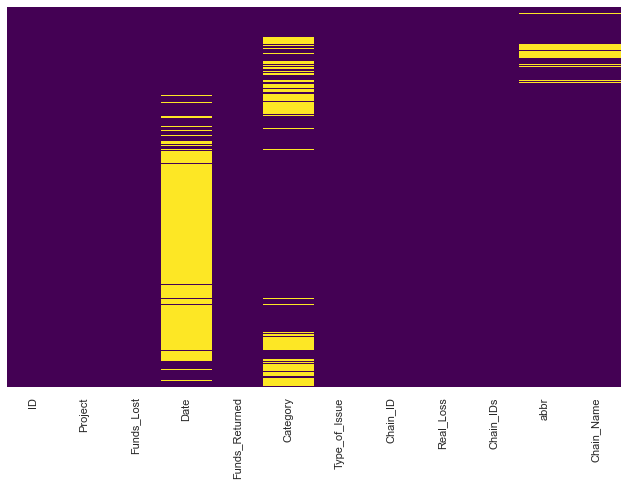

In [136]:
sns.set(rc={'figure.figsize':(11,7)})
sns.heatmap(main_df.isnull(), yticklabels=False, cbar=False, cmap= 'viridis')  #We can see the visualized versin of missing values.

<i> We have quite amount of missing values for Date column.

In [137]:
main_df.count() #numer of non-missing values

ID                3167
Project           3167
Funds_Lost        3167
Date              1302
Funds_Returned    3167
Category          2401
Type_of_Issue     3167
Chain_ID          3167
Real_Loss         3167
Chain_IDs         3167
abbr              2987
Chain_Name        2987
dtype: int64

## Visualizations of insights

### Categories

In [138]:
main_df['Category'].value_counts(dropna=False) # most of the scams and hacks have happened for 'Token' category

Token                                              1916
None                                                766
Exchange (DEX)                                      127
CeFi                                                122
Other                                                48
Borrowing and Lending                                47
Yield Aggregator                                     33
NFT                                                  20
Stablecoin                                           19
Gaming / Metaverse                                   14
Bridge                                               10
Borrowing and Lending,Exchange (DEX)                  5
Gaming / Metaverse,NFT                                4
Other,Token                                           3
Exchange (DEX),Yield Aggregator                       3
Borrowing and Lending,CeFi                            3
Borrowing and Lending,Other                           2
Gaming / Metaverse,Token                        

In [139]:
category_grouped = main_df.groupby(['Category'])['Real_Loss'].sum().sort_values(ascending=False).reset_index()

fig = px.bar(category_grouped, x='Category', y='Real_Loss', color='Category')
fig.show()

<i> <b> The table above shows <font color='red'> Stablecoin scams </font> had the highest Real_Loss amount

### Chain_Name

In [140]:
chain_grouped = main_df.groupby(['Chain_Name'])['Real_Loss'].sum().sort_values(ascending=False).reset_index()

fig = px.bar(chain_grouped, x='Chain_Name', y='Real_Loss')
fig.show()

<i> <b> Cardano, Ethereum and Binance chains have the highest amounts of loss

### Type_of_Issue

In [141]:
issue_grouped = main_df.groupby(['Type_of_Issue'])['Real_Loss'].sum().sort_values(ascending=False).reset_index()

fig = px.bar(issue_grouped, x='Type_of_Issue', y='Real_Loss')
fig.show()

<i> <b> According to the bar chart, besides <font color='red'> 'Other' </font> issue type, <font color='red'> 'Rugpull' </font> and '<font color='red'> 'Access Control' </font> types have the highest amounts of Real_Loss

### <i><font color='red' > 'Real_Loss' grouped by 'Date' 

In [146]:
# As we only have 40% of Date values present, but there is a fact that there are no Real_Loss amount for the missing dates
# Therefore, I created another dataframe by dropping missing values and created visualization of Reall Loss over time.

main_df_date = main_df[main_df['Date'] != '0000-00-00']
main_df_date['Date'] = pd.to_datetime(main_df_date['Date'])

grouped_df = main_df_date.groupby(pd.Grouper(key='Date', freq='M'))['Real_Loss'].sum().reset_index()

grouped_df['Year'] = grouped_df['Date'].dt.year
grouped_df['Month'] = grouped_df['Date'].dt.month


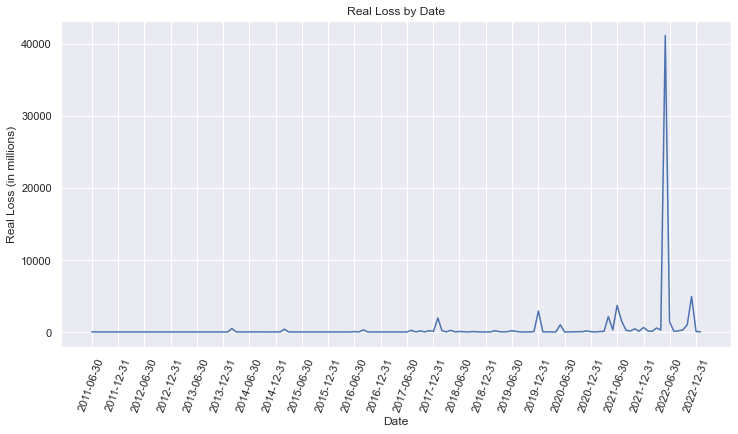

In [147]:
plt.figure(figsize=(12,6))
plt.plot(grouped_df['Date'], grouped_df['Real_Loss']/1000000)
plt.xlabel('Date')
plt.ylabel('Real Loss (in millions)')
plt.title('Real Loss by Date')
plt.xticks(grouped_df['Date'][::6], rotation=70)
plt.show()

<i> <b> As we can see, the <font color='red'> biggest Loss Amount </font> is encountered during the first half of the Year 2022 and it seems the Loss amount has increased a lot in the recent years.